In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML

from collections import Counter

from wordcloud import WordCloud

import warnings # ignore warnings 
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('xtick', labelsize=20) 
sns.set_style("whitegrid")
colors = ["#BBBDFF","#EB825B"]
nltk.download("stopwords");

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/skillfactory-hackaton-team9/twitter-analyzer/main/parsed_data/sentiment_from_5_models.csv", index_col=0)

In [4]:
def show_tweets(tweets, count=10, title=""):
    if(title):
        display(HTML(f"<h3>{title}</h3>"))
    for t in tweets.text.head(count):
        display(HTML(f"<li>{t}</li>"))

# Преобразуем данные для графиков

In [5]:
df.date = pd.to_datetime(df.date)
df["week"] = df["date"].to_numpy().astype("datetime64[W]")
df["r"] = 1
df.loc[df.m5_objects.isna(), "m5_objects"] = ""

# Самые частые упоминатели фонда

In [6]:
df.twitter_name.value_counts().head(10)

@orangevyy        59
@5tv              34
@hotpies8         18
@tvc_ru           15
@Zoombyru_News    13
@tvcplus          12
@miloserdie_ru    11
@Lednikova_L      10
@danilovcydd       9
@wsewmeste         9
Name: twitter_name, dtype: int64

In [7]:
df.author.value_counts().head(10)

ар2дэ2                  59
Пятый канал Новости     34
hotpies8                18
ТВ Центр                15
Новости на Zoomby.ru    13
TVC News                12
miloserdie_ru           11
Oля                     10
Волонтеры Даниловцы      9
Помогаем Все вместе      9
Name: author, dtype: int64

### Выводы:
- Обычно люди упоминают Фонд "Подари жизнь" не очень часто (Только 8 пользователей упомуло фод 10 и более раз)

# Опередилим токсичные комментарий, если любая из моделей отнесла твит к "токсичным"

## Предсказания первой модели

In [8]:
TOXIC_THRESHOLD = 0.9
df["is_toxic1"] = (df.m1_notoxic  < TOXIC_THRESHOLD).astype(int)

In [9]:
show_tweets(df.loc[df.is_toxic1 == 1], title="Токсичные твиты 1")

## Предсказания второй модели

In [10]:
TOXIC_THRESHOLD = 0.2
df["is_toxic2"] = (df.m2_toxic  > TOXIC_THRESHOLD).astype(int)

In [11]:
show_tweets(df.loc[df.is_toxic2 == 1], title="Токсичные твиты 2")

## Общие предсказания

In [12]:
df["is_toxic"] = ((df.is_toxic1 == 1) | (df.is_toxic2 == 1)).astype(int)

In [13]:
show_tweets(df.loc[df.is_toxic == 1], title="Токсичные твиты 3")

In [14]:
show_tweets(df.loc[df.is_toxic == 0], title="Нормальные твиты")

# Как часто писали твиты, и их "токсичность"

Как изменялось количеств комитов во времени ( а также количество токсичных твитов)  
И определим токсичные по данным разных моделей

In [15]:
plot_data = pd.DataFrame(df.groupby(["week", "is_toxic"]).r.count())

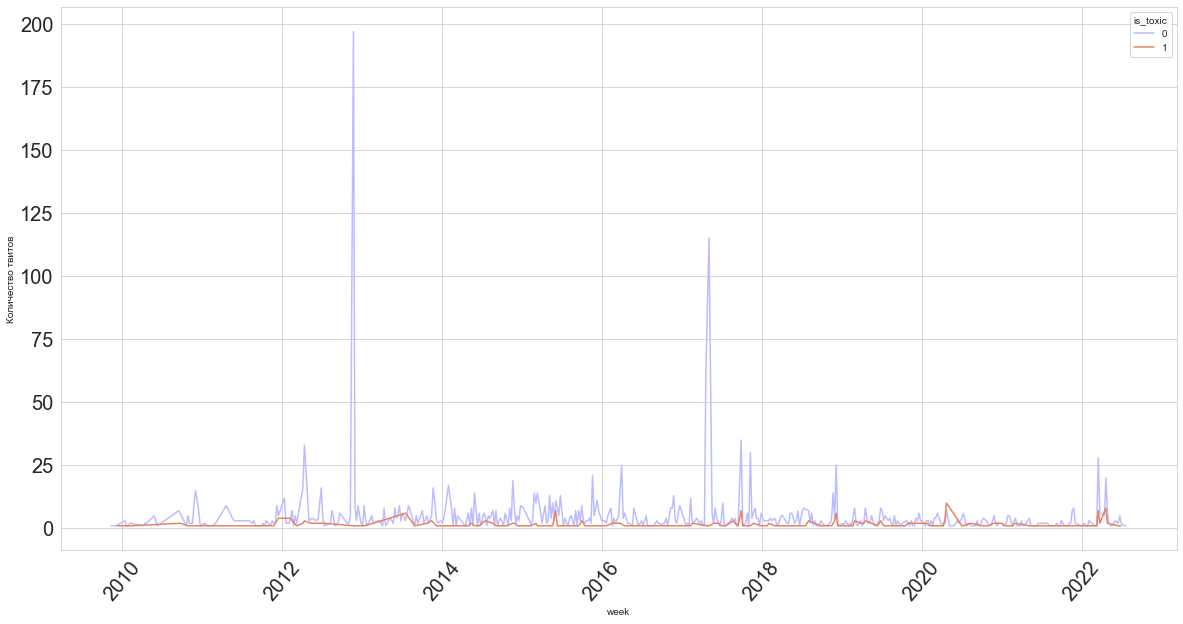

In [16]:
sns.lineplot(data=plot_data, x="week", y="r", hue="is_toxic", palette=colors);
plt.xticks(rotation=50)
plt.ylabel("Количество твитов")
plt.show()

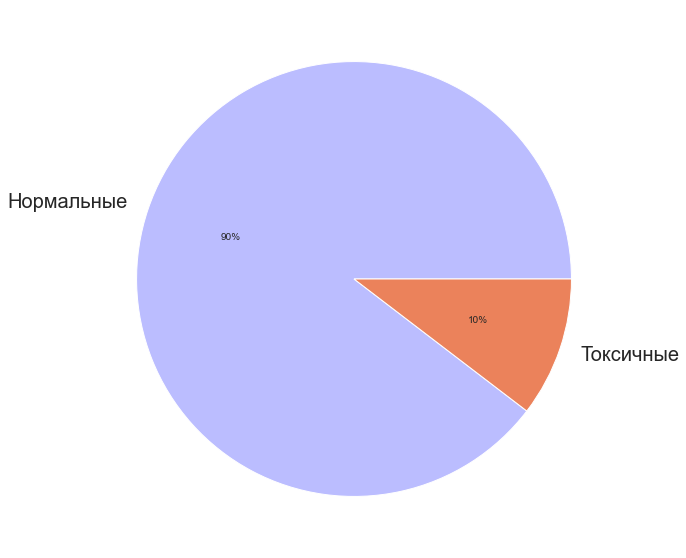

In [17]:
plt.pie(df.is_toxic.value_counts(), labels = ["Нормальные","Токсичные"], colors=colors, autopct='%.0f%%')
plt.show()

## Что писали в те недели, когда были всплески по количеству записей

In [18]:
plot_data.sort_values("r", ascending=False).head(3)

,,r
week,is_toxic,
2012-11-22,0,197
2017-05-04,0,115
2017-04-20,0,63


In [19]:
show_tweets(df.loc[df.week == '2012-11-22'], title="Ноябрь 2012")

In [20]:
show_tweets(df.loc[df.week == '2017-05-04'], title="Май 2017")

In [21]:
show_tweets(df.loc[df.week == '2017-04-20'], title="Апрель 2017")

### Выводы:
- Количество комментариев примерно равномерное, но бывают всплески
- На несколько недель выпали какие-то массовые рассылки, и они выделяются по количеству сообщений в неделю
- По оценкам наших моделей, токсичных комментариев где-то 10% от общего числа (но это определяется порогом, и может быть изменено)

# Кто чаще всего упоминается в твитах о фонде

In [22]:
stop_words = stopwords.words("russian")
stemmer = SnowballStemmer("russian")
        
def clean_text(objects):
    objects = objects.replace("@", "")
    objects = objects.replace("-", "")
    text = " ".join([stemmer.stem(w) for w in objects.split() if w not in stop_words])
    return text

## Среди всех твитов

In [23]:
text = " ".join(df.loc[:,"m5_objects"].apply(clean_text))
word_cnt = Counter(text.split())

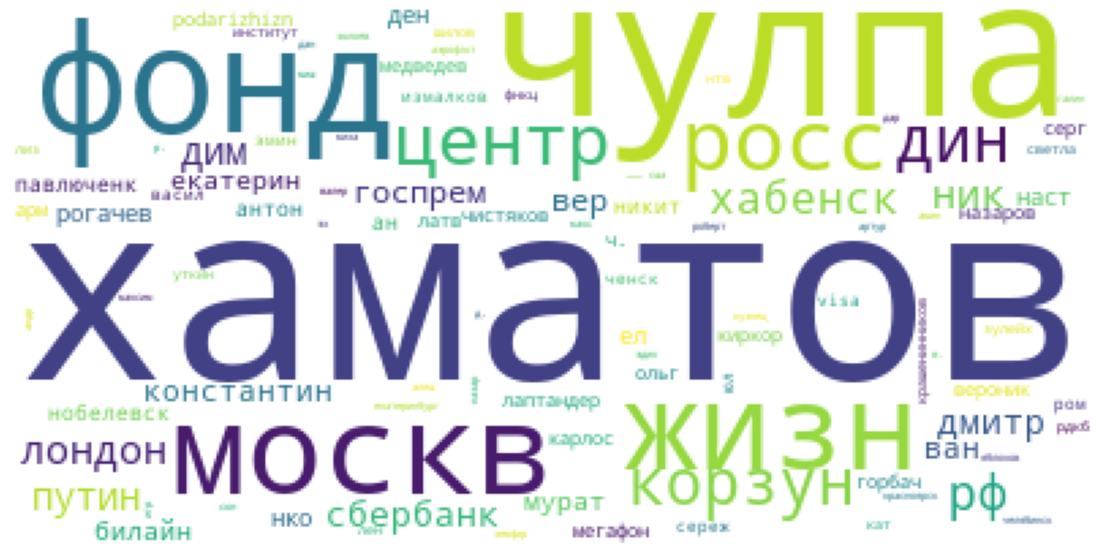

In [24]:
wordcloud = WordCloud(
    background_color="white",
    max_words=100,
    max_font_size=400, 
    relative_scaling=0.7).generate_from_frequencies(word_cnt)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [25]:
matplotlib.rc('ytick', labelsize=30) 
matplotlib.rc('xtick', labelsize=20) 

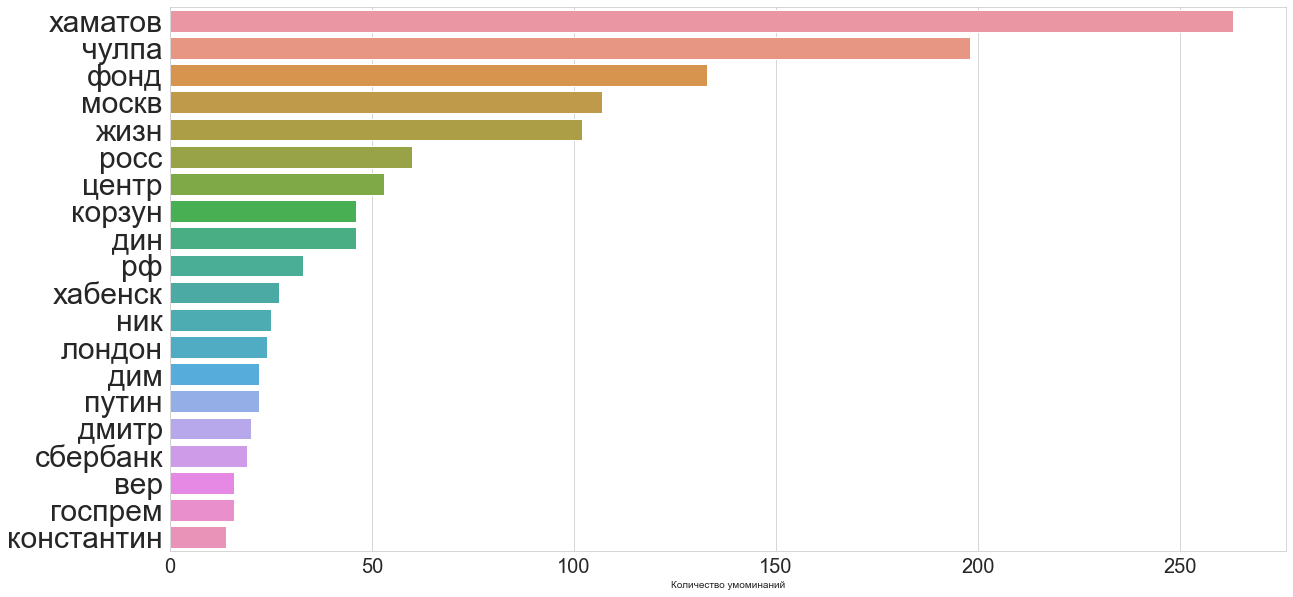

In [26]:
cnt_df = pd.DataFrame(word_cnt.most_common(20), columns=["word", "count"])
sns.barplot(data=cnt_df, y="word", x="count", orient = 'h')

plt.xlabel("Количество умоминаний")
plt.ylabel("")
plt.show();

## Среди токсичных твитов

In [27]:
text = " ".join(df.loc[df.is_toxic == 1,"m5_objects"].apply(clean_text))
word_cnt = Counter(text.split())

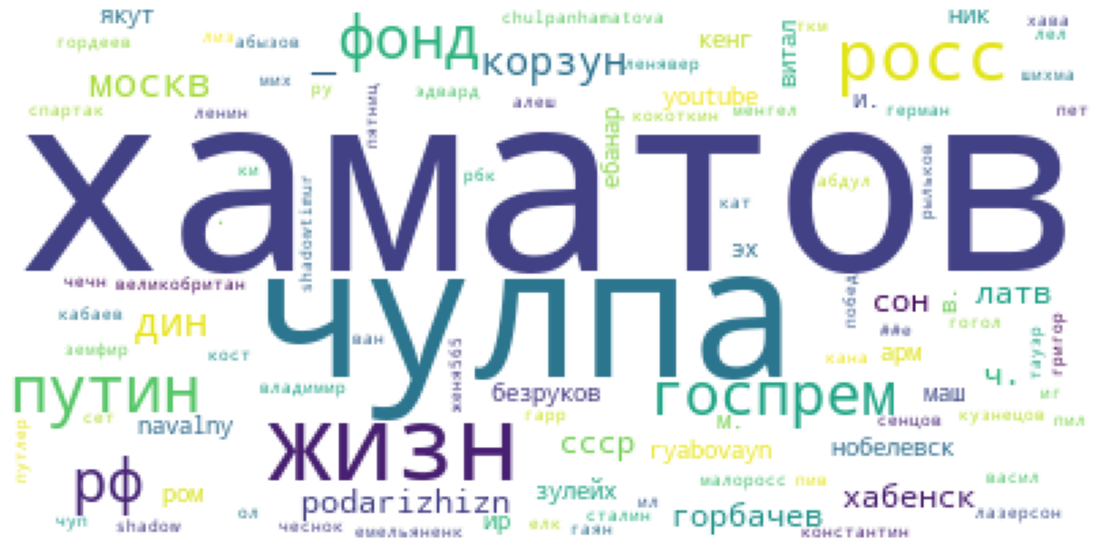

In [28]:
wordcloud = WordCloud(
    background_color="white",
    max_words=100,
    max_font_size=400, 
    relative_scaling=0.7).generate_from_frequencies(word_cnt)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

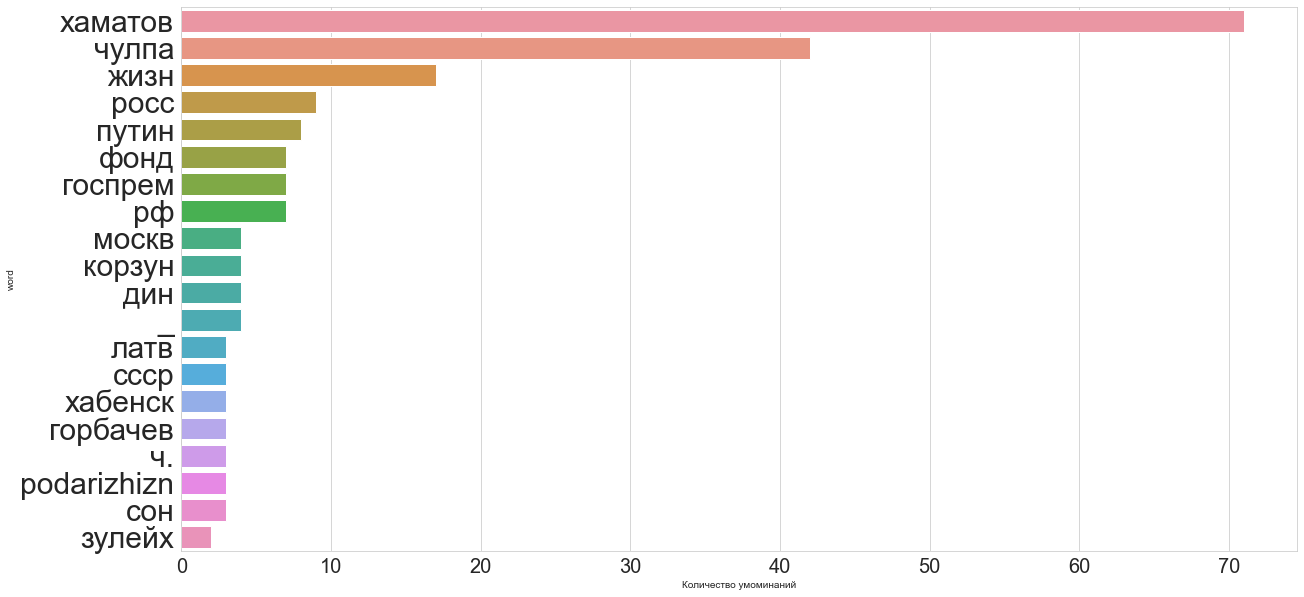

In [29]:
cnt_df = pd.DataFrame(word_cnt.most_common(20), columns=["word", "count"])
sns.barplot(data=cnt_df, y="word", x="count", orient = 'h');
plt.xlabel("Количество умоминаний")
plt.show();

### Выводы:
- Чаще всего в твитах упоминается имя Чуплан хаматовой, а тажке сам фонд подари жизнь
- Нет отличий между выделяемыми словами для токсичных и нетоксичных твитов, лидеры те же. Хотя редкие слова отличаются (чаще упоминаются другие личности)
- Из интересных упоминаний можно выделить упоминания:
    - Известных личностей: Киркоров, Дина Корзун, Хабенский, Путин, Муратов, Назаров, Павлюченко, Рогачев, Безруков, Горбачев
    - Географических мест: Москва, Россия, Латвия, Лондон, СССР
    - Организаций: Магафон, Сбербанк, Билайн, Гоголь-центр
    

# Корреляция лаков и токсичности

In [30]:
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('xtick', labelsize=20) 

In [31]:
df["number_of_likes_log"] = np.log(df.number_of_likes)
df["number_of_retweets_log"] = np.log(df.number_of_retweets)

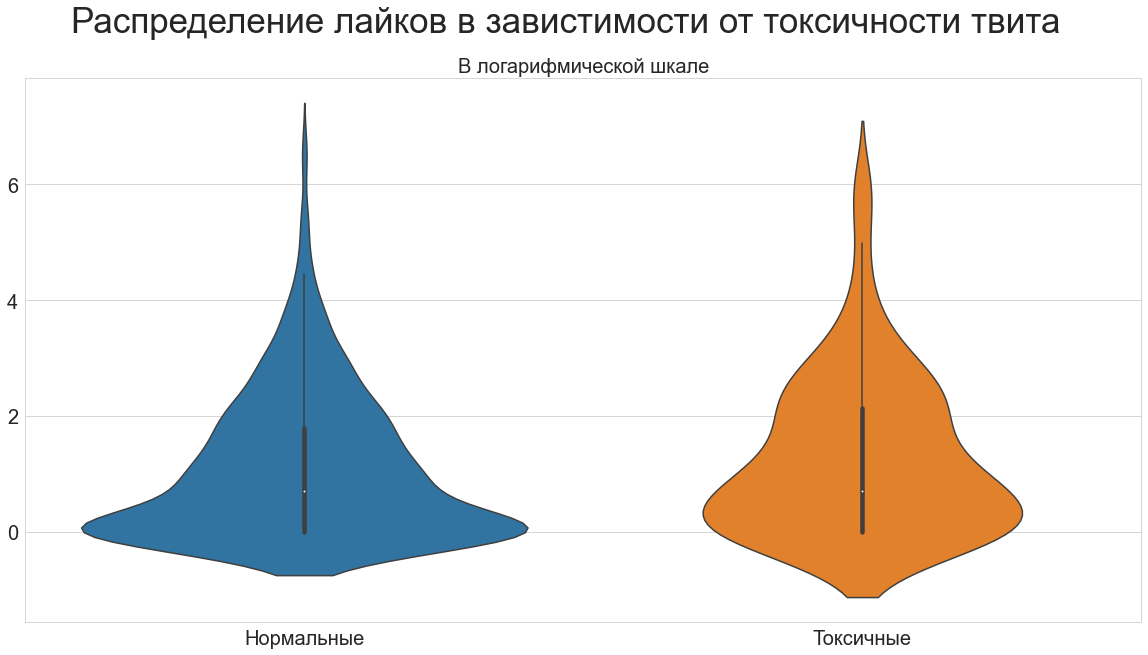

In [32]:
ax = sns.violinplot(data=df.loc[df.number_of_likes > 0], y="number_of_likes_log", x="is_toxic");
ax.set_xticklabels(['Нормальные','Токсичные',])
plt.suptitle("Распределение лайков в завистимости от токсичности твита", fontsize=35)
plt.title("В логарифмической шкале", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

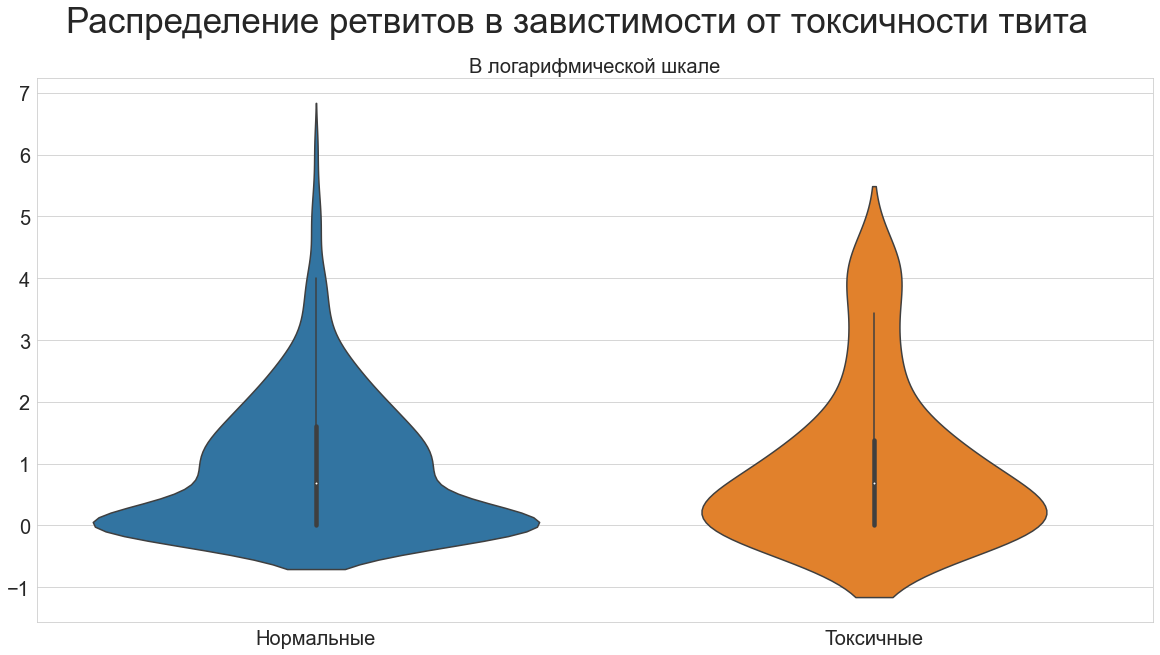

In [33]:
ax = sns.violinplot(data=df.loc[df.number_of_retweets > 0], y="number_of_retweets_log", x="is_toxic");
ax.set_xticklabels(['Нормальные','Токсичные',])
plt.suptitle("Распределение ретвитов в завистимости от токсичности твита", fontsize=35)
plt.title("В логарифмической шкале", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

### Выводы:
- Сложно сказать опредленно, но судя по форме распределения есть неболшая сконность к тому, что токсичные комментарии чаще лайкаются и ретвитятся
- Но самые залайканные твиты - это не токсичные твиты (но их и больше в выборке)

# Посмотрим что за твиты определяют наши модели

In [38]:
def show_column_info(column_name, ascending=False):
    top_tweets = df.sort_values(column_name, ascending=ascending)
    show_tweets(top_tweets, 10, column_name)

In [40]:
show_column_info("m1_notoxic", ascending=True)

In [43]:
for column in [col for col in df.columns if col.startswith("m")]:
    show_column_info(column)

### Выводы по анализу топовых твитов в каждой модели:
- **m1_notoxic** - хорошо определяет токсичные комментарии
- **m1_insult** - хорошо определяет оскорбления
- **m1_obscenity** - плохо, должен определять непристойности
- **m1_threat** - угрозы, не очень понятно, часто ошибается
- **m1_dangerous** - тоже неплохо определяет твиты, которые токсичные
- **m2_toxic** - кажется что не очень хорошо определяет токсичные твиты
- **m3_joy** - определяет радостные твиты, хорошо
- **m3_sadness** - определяет грустные твиты, хорошо
- **m3_surprise** - определяет удивление, не понятно, кажется не очень
- **m3_fear** - страх, плохо
- **m3_anger** - гнев, хорошо
- **m4_hapiness** - счаастливые твиты, хорошо
- **m4_sadness** - грустные твиты, хорошо
- **m4_enthusiasm** - твиты с энтузиазмом, плохо 
- **m4_fear** - страх, плохо
- **m4_anger** - гнев, плохо
- **m4_disqust** - отвращение, плохо



# Посмотрим категории твитов

Мы с помощью модели NLP разделили твиты на 7 категорий:
- новости о фонде
- переведем в фонд
- перевел пожертвование
- политический твит
- проблемы фонда
- просьба пожертвования
- упоминание в хорошем контексте

In [10]:
df_categ = pd.read_csv("../parsed_data/twitter_with_category.csv", index_col=0)

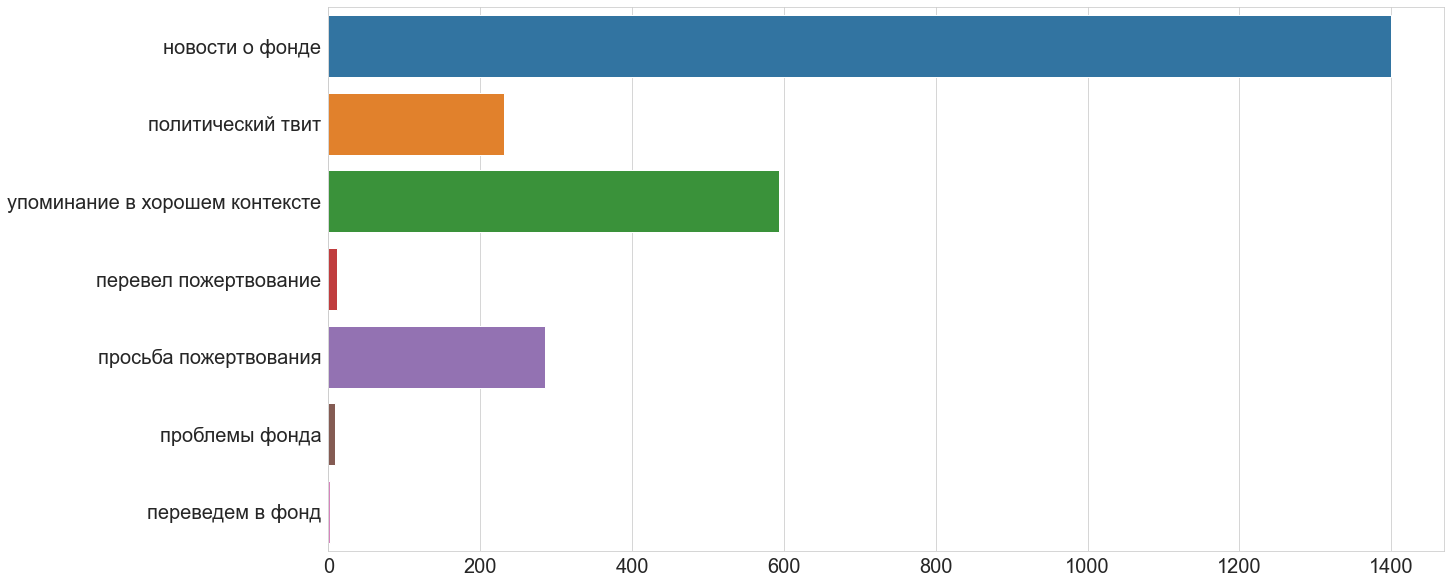

In [11]:
sns.countplot(data=df_categ, y="category", orient="h")
plt.xlabel("")
plt.ylabel("")
plt.show()

## Проверим как определяются категории

In [21]:
def show_category_info(category):
    categ_tweets = df_categ.loc[df_categ.category == category]
    categ_tweets = categ_tweets.sample(min(10, categ_tweets.shape[0]))
    show_tweets(categ_tweets, 10, category)

In [22]:
for c in df_categ.category.unique():
    show_category_info(c)